In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import pandas as pd
import math
from multiprocessing import Pool
import pickle
from sklearn import metrics

In [29]:
#score_table = create_score_table(sequence_list[0], sequence_list[1], match_matrix, -5, -2)
#match1, match2, score = create_match_strings(score_table, sequence_list[0], sequence_list[1])
type(score) is np.int64

True

In [2]:
def read_sequences(dir):
    """
    Creates a list of sequence objects from directory 'dir'
    
    Input: Directory where fasta sequences are held
    Output: List of sequence objects
    """
    ## Only get files that end in .fa
    files = glob.glob(dir + '/*.fa')
    
    ## Initialize sequnce object list
    sequences = []
    
    ## Send all found files to the read_sequence function
    for filepath in glob.iglob(os.path.join(dir, "*.fa")):
        sequences.append(read_sequence(filepath))
        
    return(sequences)


def read_sequence(filepath):
    """
    Creates a sequence object from a file.
    
    Input: Filepath to create sequence from
    Output: Sequence object
    """
    
    basename = os.path.basename(filepath)
    name = os.path.splitext(basename)
    
    ## Make sure it is a fasta file
    if name[1] != ".fa":
        raise IOError("%s is not a Fasta file"%filepath)
    
    ## Initialize the sequence object with the filename (without '.fa')
    sequence = Sequence(name[0])
    
    ## Start up residue numbering
    res_num = 1
    with open(filepath, "r") as f:
        for line in f:
            
            ## Strip newlines
            line = line.rstrip()
            
            ## Dont read in the identity line
            if line [0] != '>':
                
                ## For character in the line, add the char to sequence.residues, along with
                ## the residue number
                for i in range(0, len(line)):
                    sequence.residues.append(Residue(line[i], res_num))
                    res_num += 1
    
    return(sequence)

In [3]:
class Sequence:
    def __init__(self, name):
        self.name = name
        self.residues = []
        
    def __repr__(self):
        return self.name

class Residue:

    def __init__(self, type, number):
        self.type = type
        self.number = number
    
    def __repr__(self):
        return "{0} {1}".format(self.type, self.number)

In [4]:
def read_match_matrix(dir, name):
    """
    Creates a pandas dataframe from a scoring matrix.
    
    Input: Directory where the scoring matrix is found
           Name of the scoring matrix file
    
    Output: Pandas dataframe with scores
    """
    
    ## Find the file
    file = glob.glob(dir + "/" + name)
    
    ## Pointless loop that only goes once
    for filepath in file:
        
        with open(filepath, 'r') as f:
            
            ## Need to be able to tell when the first line happens to get the index names
            line_count = 1
            
            for line in f:
                ## Take out the newlines and split every line into single elements
                line = line.rstrip()
                line = line.split()
                
                ## If it is not a comment line
                if line[0] != '#':
                    
                    ## Use the first line to initialize the dataframe with index and column names
                    if line_count == 1:
                        match_matrix = pd.DataFrame(np.zeros((len(line), len(line)), np.int8), index=line, columns=line)
                    else:
                        
                        ## Throw all of the values into the dataframe, cast values as ints
                        match_matrix.iloc[line_count - 2] = [int(l) for l in line]

                    line_count += 1
    
    return match_matrix

def read_match_pairs(dir, name):
    """
    Creates a list of pairs, which are themselvs lists. Pair names come from a file.
    
    Input: Directory where pair file is found
           Name of pair file
    Output: List of lists
    """
    ## Get the file path, this time I took out the pointless for loop
    file = glob.glob(dir + "/" + name + ".txt")[0]
    
    with open(file, 'r') as f:
        ## Initialize the list of pairs
        pair_list = []
        
        for line in f:
            
            ## Take out the new lines, then split each line into two using " " as a delim
            line = line.rstrip()
            line = line.split(" ")
            
            ## Initialize the pair list
            pair = []
            
            ## Each line is a pair
            for element in line:
                
                ## Take out the needless parts of the pair names
                element = element.split("/")[1]
                element = element.split(".")[0]
                
                ## Add each name to the pair
                pair.append(element)
            
            ## Add the pair to the list of pairs
            pair_list.append(pair)
    return(pair_list)

def match_score(match1, match2, match_matrix):
    """
    Find the score of matching match1 with match2 in the match_matrix
    
    Input: Index name to match (residue type)
           Column name to match (residue type)
           Dataframe with scores
    Output: Score (int)
    """
    try:
        return(match_matrix[match1.upper()][match2.upper()])
    except KeyError:
        print("Whoops! Those residues were not found in the match matrix.")
        print(match1)
        print(match2)


def create_score_table(sequence1, sequence2, match_matrix, gap_open, gap_cont):
    """
    Based on the residue match scores found in match_matrix, this function computes a score table for
    every single residue combination. These scores are computed from the top left of the table to the bottom right.
    
    Along with the scores, a direction vector is included in every cell, indicating the path of best score propogation.
    
    Input: First sequence object to match
           Second sequence object to match
           DataFrame of residue match scores
           Gap opening penalty
           Gap continue penalty
    
    Output: DataFrame with len(sequence1)+1 rows and len(sequence2)+1 columns, with scores for each combination.
    """
    
    ## Initialize a general gap_score variable that we can change for opening and continuing
    gap_score = gap_open
    
    ## Initialize a datatype for our dataframe cells for an int score and a direction vector
    dt = np.dtype([('score', np.int8), ('direction', str, 3)])
    
    ## Initialize the np array to build the dataframe from, extra row and column are for pure gap scores
    initial_table = np.empty((len(sequence1.residues)+1, len(sequence2.residues)+1), dtype=dt)
    
    ## Initialize the score dataframe with sequence.residue numbers as index and col names
    score_table = pd.DataFrame(initial_table, 
                               index=["gap"] + [resi.number for resi in sequence1.residues],
                              columns=["gap"] + [resi.number for resi in sequence2.residues],
                              dtype=None)
    
    ## Initialize the top right score to be 0 with no direction vector
    score_table.iloc[0][0] = (0, '---')
    
    ## Initialize the gap row and column, which would represent an alignment of pure gaps
    for residue1 in sequence1.residues:
        
        ## For the gap column, we want to make all the direction vectors point up
        if residue1.number == 1:
            
            ## If it is the first gap score, use gap_open
            score_table.iloc[residue1.number][0] = (gap_open, '-u-')
        else:
            
            ## If not the first gap score, add the previous row score to the gap continue score
            score_table.iloc[residue1.number][0] = (score_table.iloc[residue1.number-1][0][0] + gap_cont, '-u-')
    
    
    ## Do the same things for the row of pure gaps
    for residue2 in sequence2.residues:
        if residue2.number == 1:
            score_table.iloc[0][residue2.number] = (gap_open, '--l')
        else:
            score_table.iloc[0][residue2.number] = (score_table.iloc[0][residue2.number-1][0] + gap_cont, '--l')
    
    
    
    ## This is the meat of the algorithm, iterate over every combination of residues in sequence1 and sequence2
    for residue1 in sequence1.residues:
        for residue2 in sequence2.residues:
            
            ## Initialize a score list with the score of the previous diagonal match + the score of the new match
            ## The direction vector for this option would be diagonal because that was the movement it represents
            score_list = [(score_table.iloc[residue1.number-1][residue2.number-1][0] + match_score(residue1.type,
                                                                                               residue2.type, 
                                                                                               match_matrix), 'd--')]
            
            
            ## Before computing the up direction gap scores, 
            ## check to see if there already is a gap in the up direction
            if 'u' in score_table.iloc[residue1.number-1, residue2.number][1]:
                gap_up = gap_cont
            else:
                gap_up = gap_open
            
            ## Add a score for moving down (with a vector that points back up)
            score_list.append((score_table.iloc[residue1.number-1, residue2.number][0] + gap_up, '-u-'))
            
            ## Do the same thing for the left direction gap scores
            if 'l' in score_table.iloc[residue1.number, residue2.number-1][1]:
                gap_left = gap_cont
            else:
                gap_left = gap_open
            
            ## Add a score for moving right (with a vector that points back left)
            score_list.append((score_table.iloc[residue1.number, residue2.number-1][0] + gap_left, '--l'))
            
            ## Add a zero score with no direction vector (for smith-waterman algorithm)
            score_list.append((0, '---'))
            
            ## Out of all the scores in the score list, find the max
            greatest_score = max([score[0] for score in score_list])
            
            ## Grab all scores + directions for every score that equals the max score
            greatest_scores_raw = [score for score in score_list if score[0] == greatest_score]
            
            ## Initialize a final direction string
            direction_string = list('---')            
            
            ## For every greatest score found, add the direction associated with the score to the final
            ## direction string
            for score in greatest_scores_raw:
                if score[1] == 'd--':
                    direction_string[0] = 'd'
                elif score[1] == '-u-':
                    direction_string[1] = 'u'
                elif score[1] == '--l':
                    direction_string[2] = 'l'
                else:
                    None
            
            ## Turning the direction string back into a string
            direction_string = "".join(direction_string)
            
            ## Put the greatest score and direction string together in a tuple
            score_entry = (greatest_score, direction_string)
            
            ## Put the tuple into the score table for this residue combination
            score_table[residue2.number][residue1.number] = score_entry
            
    return(score_table)


def create_match_strings(score_table, sequence1, sequence2):
    """
    From a score table computed by create_score_table, create a match between sequence1 and sequence2 by finding
    the max score in the score table and following the direction vectors back to 0, saving all the matches along
    the way.
    
    Input: Dataframe of match scores and directions
           Sequence object to match
           Sequence object to match
    
    Output: list of matched residues for sequence1
            list of matched residues for sequence2
            Max score from which the matches were started from
    """
    
    ## Find the largest score in the table, take the first if there are multiple
    largest_score = score_table.max(axis=1).max()[0]
    
    ## Initialize a furthest match location (to find the match that is closest to the bottom right)
    furthest_match = (0, 0)
    
    ## Iterate through all of the rows and columns
    for row in score_table.index:
        for column in score_table.columns:
            
            ## If any score equals the largest score and has a further position than any other largest score,
            ## save the position of this score
            if score_table[column][row][0] == largest_score:
                if column + row > furthest_match[0] + furthest_match[1]:
                    furthest_match = (row, column)
    
    
    ## Initialize the residue match strings
    match_string1 = []
    match_string2 = []
    
    ## Initialize the starting match location to be the furthest match location
    match_coord = furthest_match
    
    ## Initialize the current score to be the largest score
    current_score = largest_score
    
    ## Follow the match directions until the score falls to 0
    while current_score > 0:
        
        ## Get the value of the score table cell for the match coordinates
        current_match = score_table[match_coord[1]][match_coord[0]]
        
        ## Extract the direction vector as a list of characters
        current_direction = list(current_match[1])
        
        ## Replace current score with this new match score
        current_score = current_match[0]
        
        ## If there is a diagonal in the direction vector
        if current_direction[0] == 'd':
            
            ## Add the residues at the current coordinates to the match strings
            match_string1.append(sequence1.residues[match_coord[0]-1].type)
            match_string2.append(sequence2.residues[match_coord[1]-1].type)
            
            ## Update the coordinate to correspond with diagonal movement
            match_coord = (match_coord[0]-1, match_coord[1]-1)
        
        ## If there is an up in the direction vector
        elif current_direction[1] == 'u':
            
            ## Only add a matched residue to sequence1, the other match string gets a gap
            match_string1.append(sequence1.residues[match_coord[0]-1].type)
            match_string2.append("-")
            
            ## Move the coordinates up one
            match_coord = (match_coord[0]-1, match_coord[1])
        
        ## If there is a left in the direction vector
        elif current_direction[2] == 'l':
            
            ## Do the opposite of the last one
            match_string1.append("-")
            match_string2.append(sequence2.residues[match_coord[1]-1].type)

            match_coord = (match_coord[0], match_coord[1]-1)
        
        ## If there is no direction in the direction vector, pop the last element off because we went too far
        else:
            match_string1.pop()
            match_string2.pop()
        
        ## Bug fix where match coord got down to 0 and the index didnt work
        if match_coord[0] == 0:
            match_coord = ("gap", match_coord[1])
        if match_coord[1] == 0:
            match_coord = (match_coord[0], "gap")
            
    return (match_string1, match_string2, largest_score)

In [5]:
"""
Read in all of the sequences, create the match scoring matrix, create a list of all positive
and negative pairs.
"""
sequence_list = read_sequences("sequences/")
match_matrix = read_match_matrix(".", "BLOSUM50")
neg_pairs = read_match_pairs('.', 'Negpairs')
pos_pairs = read_match_pairs('.', 'Pospairs')

In [6]:
## Moved the computation to a server, generating pickle files that are brought back over

## These two functions are identical, except for being fed positive or negative matches
#  I will only explain one.
def positive_match(x):
    """
    This is the function to feed all of the positive matches through the score table creation
    and match scoring functions. To make this feasible over a reasonable time scale, I have
    implemented a parallel computing library.
    
    The parallel computing function I am using, Pool, only takes in a single function and a
    single argument (which is a list that it iterates through in parallel). Because of this,
    I had to create this function in a way that it would only rely on a single input, and
    ideally, have a single output.
    
    The part that is being put in parallel is the 20 gap opening scores.
    
    Input: Gap opening score
    Output: Dictionary with key of (x, gap_continue_penalty) and value of a positive match 
            score list.
    """
    
    ## Initialize the output dictionary
    all_pos_scores_in_f = {}
    
    ## Looping over all gap cont. penalties
    for cont_p in range(1, 6, 1):
        
        ## Generate the dictionary key
        key = (x, cont_p)
        
        ## Declare how many of the matches to iterate over (helpful for testing)
        iterations = 50
        
        ## Initialize the dictionary value
        pos_scores_list = []
        
        ## Loop up to the desired number of sequence pairs
        for i in range(0,iterations):
            
            ## Extract sequence pair i from the pos_pairs list
            pos_pair = pos_pairs[i]
            sequence1 = [sequence for sequence in sequence_list if sequence.name == pos_pair[0]][0]
            sequence2 = [sequence for sequence in sequence_list if sequence.name == pos_pair[1]][0]
            
            ## Create a score table from the sequence pair with gap_open = -x and gap_cont = -cont_p
            working_score_table = create_score_table(sequence1, sequence2, match_matrix, -x, -cont_p)
            
            ## Generate the match strings and score
            match_string1, match_string2, score = create_match_strings(working_score_table, sequence1, sequence2)
            
            ## Append these values to the list that will be added to the dictionary
            pos_scores_list.append((score, match_string1, match_string2))
        
        ## Once the desired number of pairs have been scored, add the scores to the dictionary
        all_pos_scores_in_f.update({key: pos_scores_list})
        
        ## Just to make sure things are running correctly
        print(key)
     
    ## Return the dictionary
    return all_pos_scores_in_f

        
def negative_match(x):
    """
    Exactly the same as positive_match, except with negative match pairs.
    
    Input: Gap opening score
    Output: Dictionary with key of (x, gap_continue_penalty) and value of a negative match 
            score list.
    """
    
    all_neg_scores_in_f = {}
    
    for cont_p in range(1, 6, 1):
        key = (x, cont_p)
        iterations = 50
        neg_scores_list = []

        for i in range(0,iterations):
            neg_pair = neg_pairs[i]
            sequence1 = [sequence for sequence in sequence_list if sequence.name == neg_pair[0]][0]
            sequence2 = [sequence for sequence in sequence_list if sequence.name == neg_pair[1]][0]

            working_score_table = create_score_table(sequence1, sequence2, match_matrix, -x, -cont_p)
            match_string1, match_string2, score = create_match_strings(working_score_table, sequence1, sequence2)

            neg_scores_list.append((score, match_string1, match_string2))

        all_neg_scores_in_f.update({key: neg_scores_list})
        print(key)
    
    return all_neg_scores_in_f


## Initialize the dictionaries of all positive and negative scores
all_pos_scores_dic = {}
all_neg_scores_dic = {}        

"""
Here is the parallel part, it is commented out because I moved the running of it to a server.
Pool is from the multiprocessing package, and the map function is a nice, one line way
of calling the parallel threads.

Once finished, the dictionaries get written to a pickle file.
"""

#with Pool(None) as p:
#    print("Pos:")
#    dic_entry_list = p.map(positive_match, [i for i in range(1, 21, 1)])
#    print(" ")
#    [all_pos_scores_dic.update(dic) for dic in dic_entry_list]
    
#    print("Neg:")
#    dic_entry_list = p.map(negative_match, [i for i in range(1, 21, 1)])
#    print(" ")
#    [all_neg_scores_dic.update(dic) for dic in dic_entry_list]
 


#pickle.dump( all_pos_scores_dic , open( "all_pos_scores_dic.p", "wb" ) )
#pickle.dump( all_neg_scores_dic , open( "all_neg_scores_dic.p", "wb" ) )

'\nHere is the parallel part, it is commented out because I moved the running of it to a server.\nPool is from the multiprocessing package, and the map function is a nice, one line way\nof calling the parallel threads.\n\nOnce finished, the dictionaries get written to a pickle file.\n'

In [7]:
## Read in all of the pos and neg scores from the pickle file
## The pickle files were brought over from the server
pos_scores = pickle.load( open( "all_pos_scores_dic.p", "rb" ) )
neg_scores = pickle.load( open( "all_neg_scores_dic.p", "rb" ) )

# 1.1
## Determining the best gap open and gap continue penalties

In [8]:
## Create a datatype for they keys, positive rate and negative rates to make it easier to sort
dtype = [('key', str, 8), ('pos_rate', float), ('neg_rate', float)]

## Initialize a value array to hold all the previous types of values
values = []

## Loop over all of the (Gap_open, Gap_cont) keys in the pos_scores dict
for key in pos_scores.keys():
    
    ## There is a lot of shit in this list, this is to extract only the scores
    pos_score_list = [pair[0] for pair in pos_scores[key]]
    
    ## Descending sort
    pos_score_list.sort(reverse=True)
    
    ## Figure out how many scores it takes to equal 0.7 of the list length
    thresh_num = math.floor(len(pos_score_list)*0.7)
    
    ## Take the element after the 0.7 number (lists index starts at 0)
    threshold = pos_score_list[thresh_num]
    
    ## Everything above the threshold is a hit. Divide by the total size of the list for a rate
    true_pos_rate = sum([1 if pair > threshold else 0 for pair in pos_score_list])/len(pos_score_list)

    ## Extract the negative scores
    neg_score_list = [pair[0] for pair in neg_scores[key]]
    
    ## Find the false positive rate in the negative score list using the threshold
    false_pos_rate = sum([1 if pair > threshold else 0 for pair in neg_score_list])/len(neg_score_list)
    
    ## Put everything in a list
    values.append((str(key), true_pos_rate, false_pos_rate))

## Put the list into a numpy array to make it easier to sort
rate_array = np.array(values, dtype=dtype)

## Sort by False positive rate
sorted_rate_array = np.sort(rate_array, order='neg_rate')

print("Best (Gap open, gap continue) scores:")
print(sorted_rate_array[0][0])
print("")

print("With a false positive rate of:")
print(sorted_rate_array[0][2])
print("")

Best (Gap open, gap continue) scores:
(10, 3)

With a false positive rate of:
0.24



With a true positive rate of 0.7, the best false positive rate for any combination of gap open, with values (1-20), and gap continues, with values (1-5), is 0.24, for gap open = 10 and gap continue = 3. There were some other combinations with the same false positive rate, but this was the first one in my sorted array.

# 1.2 
## Determining best scoring matrix

In [9]:
## Define the gap open and gap continue penalties determined previously
gap_open = 10
gap_continue = 3


## Using the supplied scoring matrices
score_matrix_names_list = ["BLOSUM50", "BLOSUM62", "MATIO", "PAM100", "PAM250"]

## Initialize dictionaries, which will use the matrix names as keys
matrix_pos_scores = {}
matrix_neg_scores = {}


## This will be iterated through for each scoring matrix
def positive_match_for_matrix(x):
    """
    This is the parallel processing function to compute matches for any defined scoring matrix (match_matrix).
    The point is to send all the sequences pairs through as fast as possible for every different scoring matrix
    
    Input: Index for what positive match pair to analyze
    Output: A list of the match score, match string for sequence1, match string for sequence2, sequence1, sequence2
    """
    
    ## I have defined all of these operations before, the only difference here is that this function is iterating
    ## over pair indices instead of gap scores
    pos_pair = pos_pairs[x]
    sequence1 = [sequence for sequence in sequence_list if sequence.name == pos_pair[0]][0]
    sequence2 = [sequence for sequence in sequence_list if sequence.name == pos_pair[1]][0]
    
    working_score_table = create_score_table(sequence1, sequence2, match_matrix, -gap_open, -gap_continue)
    match_string1, match_string2, score = create_match_strings(working_score_table, sequence1, sequence2)
    return([score, match_string1, match_string2, sequence1, sequence2])


def negative_match_for_matrix(x):
    neg_pair = neg_pairs[x]
    sequence1 = [sequence for sequence in sequence_list if sequence.name == neg_pair[0]][0]
    sequence2 = [sequence for sequence in sequence_list if sequence.name == neg_pair[1]][0]
    
    working_score_table = create_score_table(sequence1, sequence2, match_matrix, -gap_open, -gap_continue)
    match_string1, match_string2, score = create_match_strings(working_score_table, sequence1, sequence2)
    return([score, match_string1, match_string2, sequence1, sequence2])
    
"""
This part was moved to the server to speed things up. Basically we want to iterate through the match matrix names,
define a global match_matrix based on the iteration, then calculate all the scores based on that match matrix.

The results get fed into the matrix_***_scores dictionary using the matrix name as a key. Then those dictionaries
are saved as pickle files that can be brought back over to my local machine.
"""
#for matrix_name in score_matrix_names_list:
#    match_matrix = read_match_matrix(".", matrix_name)
#
#    with Pool(25) as p:
#        matrix_pos_scores[matrix_name] = p.map(positive_match_for_matrix, [i for i in range(0, 50, 1)])
#        matrix_neg_scores[matrix_name] = p.map(negative_match_for_matrix, [i for i in range(0, 50, 1)])
#
#
#pickle.dump( matrix_pos_scores , open( "matrix_pos_scores.p", "wb" ) )
#pickle.dump( matrix_neg_scores , open( "matrix_neg_scores.p", "wb" ) )

'\nThis part was moved to the server to speed things up. Basically we want to iterate through the match matrix names,\ndefine a global match_matrix based on the iteration, then calculate all the scores based on that match matrix.\n\nThe results get fed into the matrix_***_scores dictionary using the matrix name as a key. Then those dictionaries\nare saved as pickle files that can be brought back over to my local machine.\n'

In [10]:
## Feeding the pickle files back into my local pipeline
matrix_pos_scores = pickle.load( open( "matrix_pos_scores.p", "rb" ) )
matrix_neg_scores = pickle.load( open( "matrix_neg_scores.p", "rb" ) )

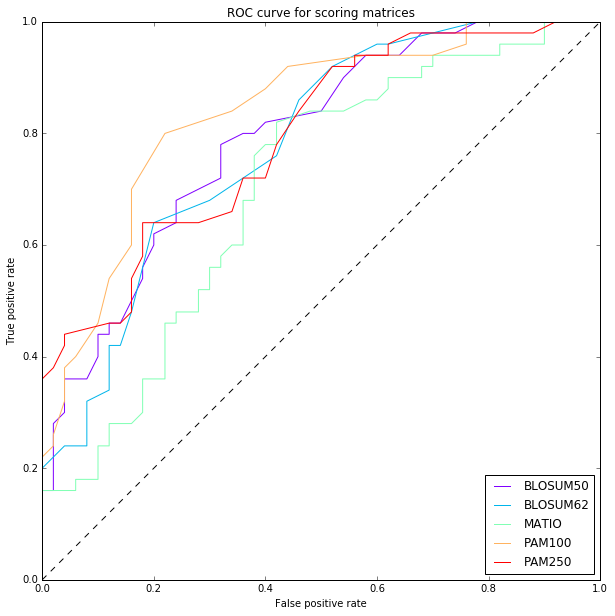

In [11]:
## Since I am using the same dictionary names for all the subsequent scoring matrix calculations, I am defining
## exactly what keys I want to feed in to this ROC graph (or else it will do everything). At this point
## I couldve put this all into a function, since the only thing changing is the title and key list, but im too lazy.

key_list = ["BLOSUM50", "BLOSUM62", "MATIO", "PAM100", "PAM250"]

## I am too lazy to specify colors
color_cycle = cm.rainbow(np.linspace(0, 1, len(key_list)))
color_iter = 0
plt.figure(figsize=(10, 10))

for key in key_list:
    
    ## For every entry under this key in the pos_scores dic, define a true value
    y_true = [1 for i in matrix_pos_scores[key]]
    
    ## For every entry under this key in the neg_scores dic, define a false value
    y_false = [0 for i in matrix_neg_scores[key]]
    
    ## Save the scores of every entry under this key in the pos_scores dic
    scores_true = [i[0] for i in matrix_pos_scores[key]]
    
    ## Save the scores of every entry under this key in the neg_scores dic
    scores_false = [i[0] for i in matrix_neg_scores[key]]
    
    ## Combine the true / false arrays
    y = np.array(y_true + y_false)
    
    ## Combine the pos / neg score arrays in the same way
    scores = np.array(scores_true + scores_false)
    
    ## Calculate the roc curve using sklearn
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    
    ## Add the line for this roc curve to the current plot
    plt.plot(fpr, tpr, label=key, color=color_cycle[color_iter])
    color_iter += 1

## Add the 1-1 line to the ROC curve
plt.plot([0,1], [0,1], 'k--', color='k')
plt.title("ROC curve for scoring matrices")
plt.legend(loc='lower right')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

Based on the ROC curve, PAM100 seems to do best overall, while MATIO seems to do worst overall.
At a true positive rate of 0.7, PAM100 absolutely does the best, with a false positive rate below 0.2, the next closest is BLOSUM50, with a false positive rate around 0.35.

I skipped finding the false positive rates for a true positive rate of 0.7 for all of these because I feel the ROC curves show that information much more completely, making that step redudant.

# 1.3
## Normalized ROC curves

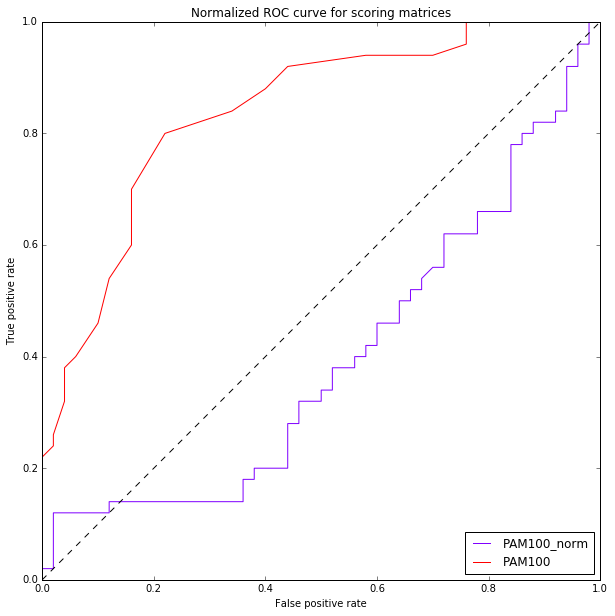

In [12]:
key_list = ["PAM100"]
color_cycle = cm.rainbow(np.linspace(0, 1, len(key_list)*2))
color_iter = 0
plt.figure(figsize=(10, 10))

for key in key_list:
    y_true = [1 for i in matrix_pos_scores[key]]
    y_false = [0 for i in matrix_neg_scores[key]]
    
    
    ## This is the only part that is different from the previous cell, so here I get the length of each
    ## sequence object and divide the score by the min length to normalize.
    norm_scores_true = []
    for i in matrix_pos_scores[key]:
        norm = i[0] / min(len(i[3].residues), len(i[4].residues))
        norm_scores_true.append(norm)
    
    norm_scores_false = []
    for i in matrix_neg_scores[key]:
        norm = i[0] / min(len(i[3].residues), len(i[4].residues))
        norm_scores_false.append(norm)
        
        
    ## This is for the unnormalized scores
    scores_true = [i[0] for i in matrix_pos_scores[key]]
    scores_false = [i[0] for i in matrix_neg_scores[key]]
    
    y = np.array(y_true + y_false)
    norm_scores = np.array(norm_scores_true + norm_scores_false)
    scores = np.array(scores_true + scores_false)
    
    n_fpr, n_tpr, n_thresholds = metrics.roc_curve(y, norm_scores)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    
    plt.plot(n_fpr, n_tpr, label=key+"_norm", color=color_cycle[color_iter])
    color_iter += 1
    
    plt.plot(fpr, tpr, label=key, color=color_cycle[color_iter])
    color_iter += 1

    
plt.plot([0,1], [0,1], 'k--', color='k')
plt.title("Normalized ROC curve for scoring matrices")
plt.legend(loc='lower right')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

False positive rates increase dramatically after normalization. I think this is because sequence length does not significantly matter in regards to what the score will be. In the Smith-waterman algorithm, we are not trying to match the whole sequence together, rather we try to find the greatest substring match anywhere in the two sequences. The way sequence length would effect this is by increasing the chances of random things being good matches, but to add up to a good score, there needs to be a long, connected string of these good matches, which is very unlikely to happen by random chance.

# 2.1
## Optimization algorithm

The goal of this is to optimize the scoring matrix so that true positive rate will be maximized and false positive rate will be minimized. This will be shown through an increase in tpr for low fpr, which will be quantified through an objective function.

To make this optimization, I will be treating each element of the scoring matrix as a weight, then use the gradient descent algorithm to iteratively adjust these weights in a way that maximizes the difference between tpr and fpr for the training data.

Getting more in depth into how this will work:
- Use the alignments generated from the PAM100 scoring matrix as a static set of data to train against.
- Create a scoring function that will rescore alignments based on the updated weights
- Update the weights in a way that decreases the error between predicted and actual
- Repeat this process a bunch of times

A caveat that came up in the end is that it worked best to have float values as weights instead of ints for optimization, but my whole pipeline for using the scoring matrix was based on ints, so I had to round the float values to the nearest int. It did effect the output of the objective function, but not by much. Absolutely worth it in relation to updating everything to take floats.

# 2.2
## Optimizing starting from PAM100 matrix

In [706]:
## Define the same gap open and gap continue penalties as before
gap_open = 10
gap_continue = 3

## Start off with the best scoring matrix
best_score_matrix = "PAM100"

## Define a new matrix that we will modify, initialized by the best scoring matrix
custom_matrix = read_match_matrix(".", best_score_matrix)

## This function takes a score as input and says whether the alignment is a match (value close to 1) or not a match 
## value close to 0
def sigmoid_activation(x):
    """
    This function takes a score as input and says whether the alignment is a match (which would have a value > 0.5)
    Or not a match, which would have a value < 0.5. Ideally this gives strong separation of what is a match or not
    with match values being very close to 1, and non matches being very close to 0.
    
    Input: Match score
    Output: value between 0-1, signifying match or not
    """
    # compute and return the sigmoid activation value for a
    # given input value
    return 1.0 / (1 + np.exp(-x))


def score_finder(match1, match2, score_matrix, gap_o, gap_c):
    """
    This function recomputes match scores based on the score_matrix
    
    Input:  List of matched residues
            List of matched residues
            DataFrame with match scores
            Gap open penalty
            Gap continue penalty
    
    Output: Match score
    """
    ## If the alignment has residue lists of different lengths, something is wrong
    if len(match1) != len(match2):
        print("Alignments do not match up!")
        return None
    
    ## Initialize a score, and a general gap_score that can be updated to be either open or continue
    score = 0
    gap_score = gap_o
    
    
    ## Move residue by residue through the match list
    for i in range(0, len(match1)):
        
        ## If one of the match residues is a gap, subtract the gap penalty from the score
        if match1[i] == "-":
            score -= gap_score
            
            ## Update gap score to be the continue one
            gap_score = gap_c
        elif match2[i] == "-":
            score -= gap_score
            gap_score = gap_c
        
        ## Else check the score in the score matrix and add it
        else:
            score += match_score(match1[i], match2[i], score_matrix)
            
            ## Any gap that was already open is now closed, move back to the open penalty
            gap_score = gap_o
        
    return(score)


def objective(custom_matrix, pos_pairs, neg_pairs):
    """
    For a particular matrix, this function checks the true positive rate for false positive rates 
    of 0.0, 0.1, 0.2 and 0.3, then returns the sum of all the true positive rates. 
    
    The max the sum can be is 4 and the min is 0.
    
    Input:  DataFrame of match scores
            List of positive pairs
            List of negative pairs
            
    Output: Sum of the true positive rates
    """
    ## Initialize sum
    tp_sum = 0.0
    
    ## Iterate over all the false positive rates
    for fp_rate in [0.0, 0.1, 0.2, 0.3]:
        
        neg_scores = []
        pos_scores = []
        
        ## This is not good coding, but for this exercise we have the same number of positive pairs and
        ## negative pairs, I am abusing that to shorten my code.
        for i in range(0, len(neg_pairs)):
            neg_pair = neg_pairs[i]
            pos_pair = pos_pairs[i]
            
            ## Determine the score for each pair of positive and negative alignments using custom_matrix
            neg_scores.append(score_finder(neg_pair[0], neg_pair[1], custom_matrix, gap_open, gap_continue))
            pos_scores.append(score_finder(pos_pair[0], pos_pair[1], custom_matrix, gap_open, gap_continue))
        
        ## How far into neg_scores do we need to go to meet the fp_rate
        thresh_num = math.floor(len(neg_scores)*fp_rate)
        
        ## Sort neg scores and go in by thresh_num to determine a threshold
        neg_scores.sort(reverse=True)
        threshold = neg_scores[thresh_num]
        
        ## Determine true positive rate by checking how many positive scores are above the threshold
        tp_rate = sum([1 if elem > threshold else 0 for elem in pos_scores])/len(pos_scores)
        
        ## Add the rate to tp_sum
        tp_sum += tp_rate
        
        
    return(tp_sum)


def optimize(custom_matrix, pos_pairs, neg_pairs, iterations, alpha):
    """
    Optimizes the weights in custom_matrix to separate the scores of pos_pairs and neg_pairs by as much as possible.
    Checks the scores in relation to the current weights once per iteration, then based on the difference between
    the found values and the expected values, updates the weights according to some scaling factor alpha.
    
    Input:  DataFrame of match scores
            List of lists of matched residues for positive matches
            List of lists of matched residues for negative matches
            Int for how many times to iterate through the process
            Float for weight change scaling factor
    
    Output: A dictionary of weights to be turned back into a dataframe of match scores
    """
    
    ## Define what is positve and negative with 1, 0
    y = [1 for pair in pos_pairs] + [0 for pair in neg_pairs]
    
    ## Define a list of dicionaries of size y, there will be one entry for every alignment
    X_dic_list = [{} for i in y]
    
    ## Define a weight dictionary
    W_dic = {}
    
    """
    Basically at this point I want to turn both my weight dataframe and each of my alignments into one dimensional
    objects with the same length. To do this I create dictionaries out of both, the keys to these dictionaries are
    every possible combination of residues, with symmetrical matches being counted as the same.
    
    In the weight dictionary, each match key is assigned the score from the dataframe for that match.
    In the alignment dictionaries, each match key is assigned a number based on how many times that match came up
    in the alignment. This way, both dictionaries are now comparable, and the dot product of the
    weight dictionary values with the alignment dictionary values is the score of the alignment based on those weights.
    """
    
    ## Turning everything to dictionaries
    for row_name in custom_matrix.axes[0]:
        for col_name in custom_matrix.axes[1]:
            
            ## Creating a key and reverse key for every residue match
            com_name = row_name+col_name
            rev_name = col_name+row_name
            
            ## If neither the key or the reverse key is already in the weight dictionary, then define a new entry
            if com_name not in W_dic.keys() and rev_name not in W_dic.keys():
                W_dic[com_name] = custom_matrix[row_name][col_name]
                
                ## Also define entries for the alignemnt dictionaries, this is just an initialization
                for i in X_dic_list:
                    i[com_name] = 0
    
    
    ## This part counts the matches for each alignment and updates the corresponding dictionary
    for i in range(0, len(pos_pairs)):
        ## For each pair in positive pairs
        pair = pos_pairs[i]
        
        ## Iterate over each residue in the pair
        for j in range(0, len(pair[0])):
            
            ## Create a key and reverse key for every residue match
            row_name = pair[0][j]
            col_name = pair[1][j]
            
            ## If there is not a gap at this location, then add 1 to this key in the dictionary
            if row_name != '-' and col_name != '-':
                com_name = row_name+col_name
                rev_name = col_name+row_name

                try:
                    X_dic_list[i][com_name] += 1
                except KeyError:
                    X_dic_list[i][rev_name] += 1
    
    
    ## Do the exact same thing for the negative pairs, I probably couldve combined this with the positive loop
    for i in range(0, len(neg_pairs)):
        pair = neg_pairs[i]
        
        
        for j in range(0, len(pair[0])):
            row_name = pair[0][j]
            col_name = pair[1][j]
            
            if row_name != '-' and col_name != '-':
                com_name = row_name+col_name
                rev_name = col_name+row_name

                try:
                    X_dic_list[i+len(pos_pairs)][com_name] += 1
                except KeyError:
                    X_dic_list[i+len(pos_pairs)][rev_name] += 1
    
     
    ## Initialize a numpy array for both the weights and the list of positve and negative alignments
    ## The weight array and the array for each alignment have the same lengths, while X is the length of
    ## the total number of pairs
    W = np.array([0.0 for j in W_dic.keys()])
    X = np.array([[0 for j in W_dic.keys()] for i in y])

    ## Now turn the dictionary into something that can actually be worked with, what matters is that
    ## things are in the same order for the weight and alignment arrays. Since they both have the same keys,
    ## I iterate over the weight dictionary keys for both.
    for i in range(0, len(W_dic.keys())):
        
        ## This probably could be one level up, but it works here. Create a key list that can be iterated through
        key_list = list(W_dic.keys())
        
        ## Define a key
        key = key_list[i]
        
        ## Element i of the weight array is equal to this key in the weight dictionary
        W[i] = W_dic[key]
        
        ## Also for every alignment list in X, element i of each of those lists is equal to this key in the
        ## alignment dictionary. This assures that the weights and score values are aligned
        for j in range(0, len(X)):
            X[j][i] = X_dic_list[j][key]
    
    
    ## Initialize a list of error scores to make sure they are decreasing
    loss_history = []
    
    ## Initialize x values for plotting loss_history
    x = []
    
    ## Go for as many iterations as specified
    for i in range(0, iterations):
        
        ## Create a prediction for every alignment score. Scores are determined by finding the dot product of
        ## every alignment in X with W. The sigmoid activation function spits out whether it is a positive or
        ## negative match based on the score
        predictions = sigmoid_activation(X.dot(W))
        
        ## Determine how far away each prediction is from the true values in y
        error = predictions - y
        
        ## Determine the magnitude of all of the errors summed together
        loss = np.sum(error ** 2)
        
        ## Add this to the history list for plotting
        loss_history.append(loss)
        x.append(i+1)
        
        ## Compute the gradient by finding the dot product of the tranpose of X with the error. This gives
        ## a weight by weight value and direction (up or down) for reducing this error. Normalize by the
        ## number of entries in X
        gradient = X.T.dot(error) / X.shape[0]
        
        ## Update the weights based on the gradient scaled by alpha
        W += -alpha * gradient
        
    ## I had these in here to plot, but got tired of it. The error gets minimized
#    plt.plot(x, loss_history)
#    plt.title("Error by iteration")
#    plt.ylim(0, 50)
#    plt.show()
    
    ## Now feed all the weights back into the weight dictionary and return it
    for i in range(0, len(key_list)):
        key = key_list[i]
        W_dic[key] = W[i]
    
    return W_dic
    


## Created the list of positive and negative alignments, without any extra information
match1_list = [i[1] for i in matrix_pos_scores[best_score_matrix]]
match2_list = [i[2] for i in matrix_pos_scores[best_score_matrix]]
pos_list = [[match1_list[i], match2_list[i]] for i in range(0, len(match1_list))]

match1_list = [i[1] for i in matrix_neg_scores[best_score_matrix]]
match2_list = [i[2] for i in matrix_neg_scores[best_score_matrix]]
neg_list = [[match1_list[i], match2_list[i]] for i in range(0, len(match1_list))]


## Running it a shit ton of times because it goes fast and improves the score by quite a bit.
custom_scores_dic = optimize(custom_matrix, pos_list, neg_list, 1000000, 1)


In [730]:
## Now it is time to turn the weight dictionary back into a dataframe
## I am actually making two here to see the difference between the float weight values and the int weight values

## This guy is for the ints
new_custom_matrix = custom_matrix.copy()

## This guys if for the floats
df_dim = len(custom_matrix.columns)
df_rows = custom_matrix.axes[0]
df_cols = custom_matrix.axes[1]

float_custom_matrix = pd.DataFrame(np.zeros((df_dim, df_dim), dtype=np.float64),
                                  index = df_rows,
                                  columns = df_cols)


## For every key in the dictionary
for key in custom_scores_dic.keys():
    
    ## Define a row and column name (residue type)
    row_name = key[0]
    col_name = key[1]
    
    ## This is for the ints, feed the dictionary value at key into the dataframe
    ## Do it for both combinations of row and column name to take care of symmetry
    new_custom_matrix[row_name][col_name] = round(custom_scores_dic[key])
    new_custom_matrix[col_name][row_name] = round(custom_scores_dic[key])
    
    ## Do the same thing for the float matrix, but dont round
    float_custom_matrix[row_name][col_name] = custom_scores_dic[key]
    float_custom_matrix[col_name][row_name] = custom_scores_dic[key]

## Define a new key entry in the dictionary I am storing all of the scoring matrix information in
matrix_pos_scores["CUSTOM_PRE"] = []
matrix_neg_scores["CUSTOM_PRE"] = []

## Compute the scores for each alignment, and add them to the master dictionary for positive matches
## I am doing these with the int score matrix because its easier.
for i in range(0, len(pos_list)):
    pair = pos_list[i]
    score = score_finder(pair[0], pair[1], new_custom_matrix, gap_open, gap_continue)
    matrix_pos_scores['CUSTOM_PRE'].append([score, pair[0], pair[1]])

## Do the same for the negative matches
for i in range(0, len(neg_list)):
    pair = neg_list[i]
    score = score_finder(pair[0], pair[1], new_custom_matrix, gap_open, gap_continue)
    matrix_neg_scores['CUSTOM_PRE'].append([score, pair[0], pair[1]])

## Find the objective score for both the int matrix and the float matrix
int_mat_score = objective(new_custom_matrix, pos_list, neg_list)
float_mat_score = objective(float_custom_matrix, pos_list, neg_list)

## Determine the fitness of the straight PAM100 scoring matrix
pam_matrix = read_match_matrix(".", "PAM100")
pam_mat_score = objective(pam_matrix, pos_list, neg_list)
    
print("I am using the rounded matrix because it fits in better with everything else.")
print("Also the performance is not much worse")
print(" ")
print("Rounded matrix: " + str(int_mat_score))
print("Float matrix: " + str(float_mat_score))
print("PAM100 matrix: " + str(pam_mat_score))

## I am saving it so I can export it to the server for easier alignment computation 
new_custom_matrix.to_csv(r'./CUSTOM', index=None, sep=' ', mode='w')

I am using the rounded matrix because it fits in better with everything else.
Also the performance is not much worse
 
Rounded matrix: 3.62
Float matrix: 3.72
PAM100 matrix: 2.12


After optimization, there is a massive increase in the score of the objective function. The PAM100 scoring matrix had a score of 2.12, while the optimized matrix, even when rounded, has a score of 3.62.

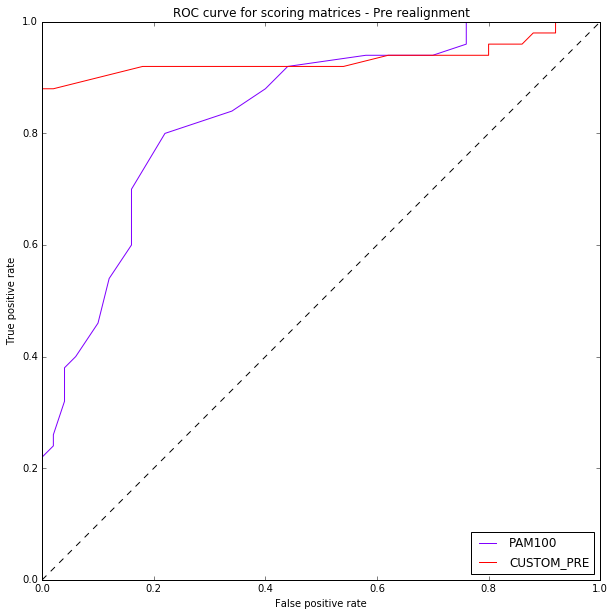

In [714]:
key_list = ["PAM100", "CUSTOM_PRE"]
color_cycle = cm.rainbow(np.linspace(0, 1, len(key_list)))
color_iter = 0
plt.figure(figsize=(10, 10))

for key in key_list:
    y_true = [1 for i in matrix_pos_scores[key]]
    y_false = [0 for i in matrix_neg_scores[key]]
    
    scores_true = [i[0] for i in matrix_pos_scores[key]]
    scores_false = [i[0] for i in matrix_neg_scores[key]]
    
    y = np.array(y_true + y_false)
    scores = np.array(scores_true + scores_false)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    
    plt.plot(fpr, tpr, label=key, color=color_cycle[color_iter])
    color_iter += 1
    
plt.plot([0,1], [0,1], 'k--', color='k')
plt.title("ROC curve for scoring matrices - Pre realignment")
plt.legend(loc='lower right')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

The ROC curve clearly shows the dramatic difference that optimization made. This is pre realignment.

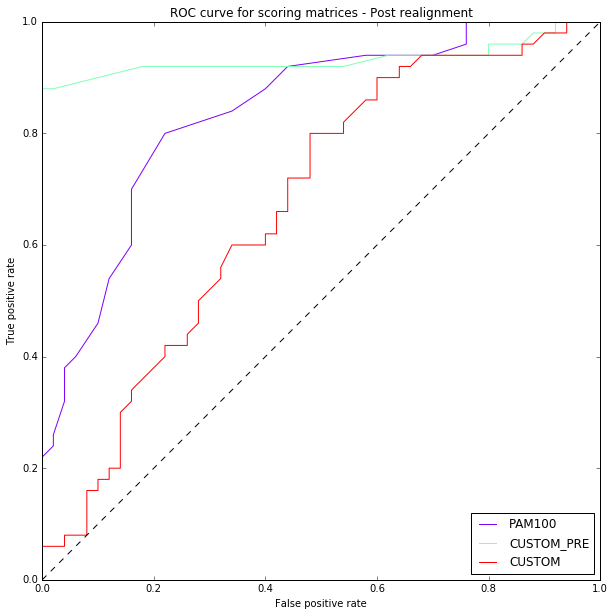

In [731]:
key_list = ["PAM100", "CUSTOM_PRE", "CUSTOM"]
color_cycle = cm.rainbow(np.linspace(0, 1, len(key_list)))
color_iter = 0
plt.figure(figsize=(10, 10))

for key in key_list:
    y_true = [1 for i in matrix_pos_scores[key]]
    y_false = [0 for i in matrix_neg_scores[key]]
    
    scores_true = [i[0] for i in matrix_pos_scores[key]]
    scores_false = [i[0] for i in matrix_neg_scores[key]]
    
    y = np.array(y_true + y_false)
    scores = np.array(scores_true + scores_false)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    
    plt.plot(fpr, tpr, label=key, color=color_cycle[color_iter])
    color_iter += 1
    
plt.plot([0,1], [0,1], 'k--', color='k')
plt.title("ROC curve for scoring matrices - Post realignment")
plt.legend(loc='lower right')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

Post realignment brings everything crashing back to reality, where the optimized score matrix actually does much worse that the PAM100 matrix. Because we were optimizing based on static alignments, and because of the small sample size,the optimization was extremely overfit, where it found correlated connections between positive and negative matches that were not actually responsible for the sequences being matched or not.

The matrix I made was extremely optimized for those specific alignments, but this optimization actually made it worse for determining other alignments.

# 2.3
## Doing the same thing starting from the MATIO matrix

In [710]:
best_score_matrix = "MATIO"
custom_matrix = read_match_matrix(".", best_score_matrix)
custom_scores_dic = optimize(custom_matrix, pos_list, neg_list, 1000000, 1)

In [716]:
## All this stuff was expained before, I probably shouldve made it into a function at this point

new_custom_matrix = custom_matrix.copy()

for key in custom_scores_dic.keys():
    row_name = key[0]
    col_name = key[1]
    
    new_custom_matrix[row_name][col_name] = round(custom_scores_dic[key])
    new_custom_matrix[col_name][row_name] = round(custom_scores_dic[key])

## New key for the new scoring matrix
matrix_pos_scores["CUSTOM_MAT_PRE"] = []
matrix_neg_scores["CUSTOM_MAT_PRE"] = []

for i in range(0, len(pos_list)):
    pair = pos_list[i]
    score = score_finder(pair[0], pair[1], new_custom_matrix, gap_open, gap_continue)
    matrix_pos_scores['CUSTOM_MAT_PRE'].append([score, pair[0], pair[1]])

for i in range(0, len(neg_list)):
    pair = neg_list[i]
    score = score_finder(pair[0], pair[1], new_custom_matrix, gap_open, gap_continue)
    matrix_neg_scores['CUSTOM_MAT_PRE'].append([score, pair[0], pair[1]])

## I am saving it so I can export it to the server for easier alignment computation 
new_custom_matrix.to_csv(r'./CUSTOM_MAT', index=None, sep=' ', mode='w')

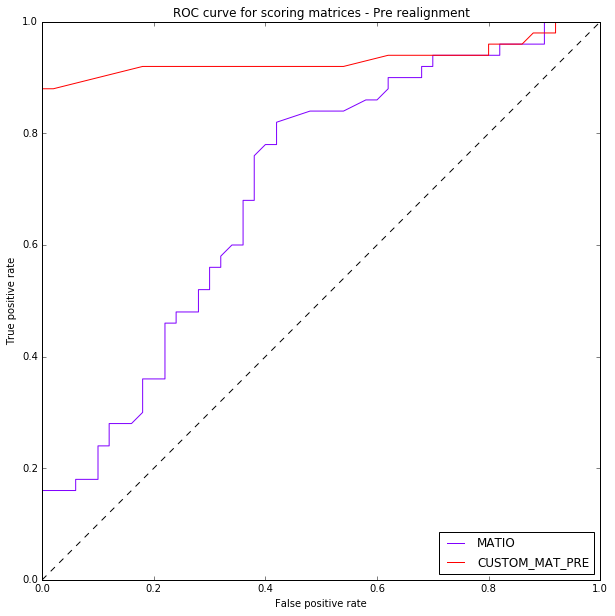

In [718]:
key_list = ["MATIO", "CUSTOM_MAT_PRE"]
color_cycle = cm.rainbow(np.linspace(0, 1, len(key_list)))
color_iter = 0
plt.figure(figsize=(10, 10))

for key in key_list:
    y_true = [1 for i in matrix_pos_scores[key]]
    y_false = [0 for i in matrix_neg_scores[key]]
    
    scores_true = [i[0] for i in matrix_pos_scores[key]]
    scores_false = [i[0] for i in matrix_neg_scores[key]]
    
    y = np.array(y_true + y_false)
    scores = np.array(scores_true + scores_false)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    
    plt.plot(fpr, tpr, label=key, color=color_cycle[color_iter])
    color_iter += 1
    
plt.plot([0,1], [0,1], 'k--', color='k')
plt.title("ROC curve for scoring matrices - Pre realignment")
plt.legend(loc='lower right')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

Looks like it doesn't matter that much how good our initial values were, this optimization ended with nearly the same fitness as optimization from the PAM100 matrix. 

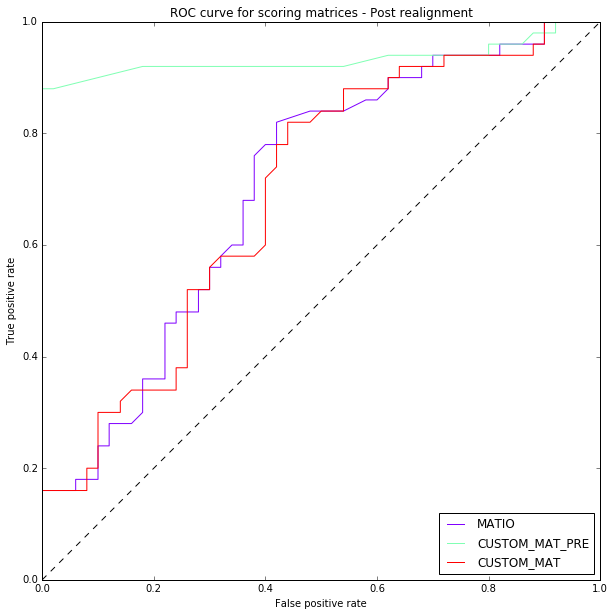

In [732]:
key_list = ["MATIO", "CUSTOM_MAT_PRE", "CUSTOM_MAT"]
color_cycle = cm.rainbow(np.linspace(0, 1, len(key_list)))
color_iter = 0
plt.figure(figsize=(10, 10))

for key in key_list:
    y_true = [1 for i in matrix_pos_scores[key]]
    y_false = [0 for i in matrix_neg_scores[key]]
    
    scores_true = [i[0] for i in matrix_pos_scores[key]]
    scores_false = [i[0] for i in matrix_neg_scores[key]]
    
    y = np.array(y_true + y_false)
    scores = np.array(scores_true + scores_false)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    
    plt.plot(fpr, tpr, label=key, color=color_cycle[color_iter])
    color_iter += 1
    
plt.plot([0,1], [0,1], 'k--', color='k')
plt.title("ROC curve for scoring matrices - Post realignment")
plt.legend(loc='lower right')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

It looks like the MATIO scoring matrix might have been made in the same way my optimized matrices were, because they produce almost identical ROC curves following realignment. Again, it is a problem of overfitting and making things important in the weight matrix that were not actually important.

These results are almost identical to 2.2

# 2.4
I used the gradient descent algorithm, trying to maximize the fitness by varying the weights. One way that my optimization could have been improved would have been realign the sequence pairs and use the scores of the new alignments to make predictions. This would have been very time intensive though, and would still run into the problem where it is being overfit to this specific dataset. An additional way to improve my optimization would be to train on random subsets of the training data, which should help alleviate some (but not all) of the overfitting problems.

# 2.5
Lots of testing, and specificity for a specific type of match. 

There are many different aspects that you could use to consider sequences "matches". If you try and target all of them, you run into the problem of having too many parameters pulling you in too many different directions. You might be able to pick out a pair better than random, but you would never be able to get it perfect, or even pretty good. What is better is to hone in one one or several specific aspects of what you would consider a sequence match to be, and create a matrix optimized for that.

Another thing that would be important is testing on a wide variety of different protein matches. It is important to capture the diversity of positive and negative matches, in regards to the matching criteria you are targeting, in order for your matrix to be reliable and robust.